In [105]:
import pandas as pd
bug_report_raw=pd.read_pickle("Output/allBugReports.pickle")
bug_report_raw = bug_report_raw[bug_report_raw['description'].notna()].reset_index()
display(bug_report_raw)

source_code_raw = pd.read_pickle("Output/allSourceCodes.pickle")
source_code_raw = source_code_raw[source_code_raw['unprocessed_code'].notna()]
display(source_code_raw)

,id,fix,text,fixdate,summary,description,project,average_precision
0,217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
1,214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
2,222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
3,261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
4,264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0
...,...,...,...,...,...,...,...,...
1785,692,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:35:48,Add tests for special chars in LegacyPropertie...,Add tests for issue https://issues.jboss.org/b...,ELY,0.0
1786,691,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:36:13,Elytron properties-realm is not compatible wit...,When users properties file (e.g. mgmt-users.pr...,ELY,0.0
1787,637,[org.wildfly.security.auth.server.serverauthen...,NaN,2016-11-03 15:03:29,No log messages comming from Elytron - permiss...,Elytron is missing any log messages related to...,ELY,0.0
1788,757,[org.wildfly.security.ssl.sslauthenticationtes...,NaN,2016-11-21 09:24:47,Don&apos;t use String toUpperCase/toLowerCase ...,The String.toUpperCase() and String.toLowerCas...,ELY,0.0


,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
...,...,...,...
63,\gitrepo\src\main\java\org\wildfly\security\ut...,"/*\n * JBoss, Home of Professional Open Source...",ELY
64,\gitrepo\src\main\java\org\wildfly\security\_p...,"/*\n * JBoss, Home of Professional Open Source...",ELY
65,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY
66,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY


## Cleaning the Data

Snowball Stemmer is used since it is a more powerful stemmer than what is used by the research paper on IRFL.
  
In addition to NLTK's stop words, Python and Java keywords have been removed to provide a better model for analysis. The Python keywords will come from a built-in library called "keyword", while Java language keywords will be extracted from a file provided by the original GitHub source found here: https://github.com/exatoa/Bench4BL/blob/master/scripts/languages.txt

Compounded words such as setValue will be split into two words, "set" and "Value".

All letters will be turned into lowercases so there would not be any distinction between "Value" and "value", for example.

In [104]:
import re, string
import pandas as pd
import numpy as np
import keyword
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
import html

%matplotlib inline

stemmer = SnowballStemmer("english")

java_keywords = None
with open('languages.txt', 'r') as file:
    java_keywords = file.read().split('\n')

def clean_text(text):
    stop_words = list(ENGLISH_STOP_WORDS) + keyword.kwlist + java_keywords
    # This is to remove the double html encodings such as &amp;apos; into simply &apos;.
    # This html encoding is easier to convert into punctuation or special characters for removal.
    text = text.replace("&amp;", '&')
    text = text.replace("\n", '')
    text = html.unescape(text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = " ".join(text.split())
    
    words = text.split(" ")
#     split words and return them if it is not in the stop words list
    words = [" ".join(re.findall('[A-Z]*[a-z]+|[A-Z]{2,}', word)) for word in words if not word in list(set(stop_words))]
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    text = re.sub(r"\s{2,}", " ", text)
    return text

print("Before:\n", bug_report_raw["description"][0])
print("\n\nAfter:\n", clean_text(bug_report_raw["description"][0]))

Before:
 flat map s entri object overwrit entri s valu entri set valu call it overwrit entri hand ve look sourc statement incorrect fall return like flat map java line object set valu object valu can remov illegal state except abstract hashed map setvalue invalid object old get valu next index parent valu valu parent valu valu parent valu valu old with code set valu item entry set valu set valu


After:
 flat map s entri object overwrit entri s valu entri set valu overwrit entri hand ve look sourc statement incorrect fall like flat map java line object set valu object valu remov illeg state hash map setvalu invalid object old valu index parent valu valu parent valu valu parent valu valu old code set valu item entri set valu set valu


In [106]:
# cleaning the description and putting the data into the text column
for index, row in bug_report_raw.iterrows():
    bug_report_raw.at[index, "description"] = clean_text(row["description"])
    bug_report_raw.at[index, "summary"] = clean_text(row["summary"])
bug_report_raw

,id,fix,text,fixdate,summary,description,project,average_precision
0,217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,flat map entri set valu overwrit entri valu,flat map s entri object overwrit entri s valu ...,COLLECTIONS,0.0
1,214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,extended properti field includ non,the field includ extended properti current ins...,COLLECTIONS,0.0
2,222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,collection util remove al actual retain al,the remove al collect collect collect remov me...,COLLECTIONS,0.0
3,261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,flat map remov doe correct valu size,flat map m flat map m integ integ m integ inte...,COLLECTIONS,0.0
4,264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,fast tree map forget compar,in line current releas replac map tree map map...,COLLECTIONS,0.0
...,...,...,...,...,...,...,...,...
1785,692,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:35:48,add test special char legacy properties securi...,add test issu https issu jboss org brows eli h...,ELY,0.0
1786,691,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:36:13,elytron properti realm compat legaci user prop...,when user properti file e g mgmt user properti...,ELY,0.0
1787,637,[org.wildfly.security.auth.server.serverauthen...,NaN,2016-11-03 15:03:29,no log messag com elytron permiss assign,elytron miss log messag relat permiss assign t...,ELY,0.0
1788,757,[org.wildfly.security.ssl.sslauthenticationtes...,NaN,2016-11-21 09:24:47,don t use string to upper cas to lower cas tes...,the string to upper cas string to lower cas me...,ELY,0.0


In [101]:
for index, row in source_code_raw.iterrows():
    joined_text = "".join(list(row["unprocessed_code"][index]))
    print(joined_text)
#     source_code_raw.at[index, "unprocessed_code"] = clean_text(row["unprocessed_code"])
    
# source_code_raw

/
*


 
*
 
 
L
i
c
e
n
s
e
d
 
t
o
 
t
h
e
 
A
p
a
c
h
e
 
S
o
f
t
w
a
r
e
 
F
o
u
n
d
a
t
i
o
n
 
(
A
S
F
)
 
u
n
d
e
r
 
o
n
e
 
o
r
 
m
o
r
e


 
*
 
 
c
o
n
t
r
i
b
u
t
o
r
 
l
i
c
e
n
s
e
 
a
g
r
e
e
m
e
n
t
s
.
 
 
S
e
e
 
t
h
e
 
N
O
T
I
C
E
 
f
i
l
e
 
d
i
s
t
r
i
b
u
t
e
d
 
w
i
t
h


 
*
 
 
t
h
i
s
 
w
o
r
k
 
f
o
r
 
a
d
d
i
t
i
o
n
a
l
 
i
n
f
o
r
m
a
t
i
o
n
 
r
e
g
a
r
d
i
n
g
 
c
o
p
y
r
i
g
h
t
 
o
w
n
e
r
s
h
i
p
.


 
*
 
 
T
h
e
 
A
S
F
 
l
i
c
e
n
s
e
s
 
t
h
i
s
 
f
i
l
e
 
t
o
 
Y
o
u
 
u
n
d
e
r
 
t
h
e
 
A
p
a
c
h
e
 
L
i
c
e
n
s
e
,
 
V
e
r
s
i
o
n
 
2
.
0


 
*
 
 
(
t
h
e
 
"
L
i
c
e
n
s
e
"
)
;
 
y
o
u
 
m
a
y
 
n
o
t
 
u
s
e
 
t
h
i
s
 
f
i
l
e
 
e
x
c
e
p
t
 
i
n
 
c
o
m
p
l
i
a
n
c
e
 
w
i
t
h


 
*
 
 
t
h
e
 
L
i
c
e
n
s
e
.
 
 
Y
o
u
 
m
a
y
 
o
b
t
a
i
n
 
a
 
c
o
p
y
 
o
f
 
t
h
e
 
L
i
c
e
n
s
e
 
a
t


 
*


 
*
 
 
 
 
 
 
h
t
t
p
:
/
/
w
c
w
.
a
p
a
c
h
e
.
o
r
g
/
l
i
c
e
n
s
e
s
/
L
I
C
E
N
S
E
/
*


 
*
 
L
i
c
e
n
s
e
d
 
t
o
 
t
h
e
 
A
p


IndexError: string index out of range

In [99]:
source_code_raw["unprocessed_code"][0]

0     /*\n *  Licensed to the Apache Software Founda...
1     /*\n *  Licensed to the Apache Software Founda...
2     /*\n *  Licensed to the Apache Software Founda...
3     /*\n *  Licensed to the Apache Software Founda...
4     /*\n *  Licensed to the Apache Software Founda...
                            ...                        
63    /*\n * JBoss, Home of Professional Open Source...
64    /*\n * JBoss, Home of Professional Open Source...
65    /*\n * JBoss, Home of Professional Open Source...
66    /*\n * JBoss, Home of Professional Open Source...
67    /*\n * JBoss, Home of Professional Open Source...
Name: unprocessed_code, Length: 10461, dtype: object

In [111]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf(X_train):
    vectorizer = TfidfVectorizer(min_df=2)  # Your solution
    # Fit the vectorizer here
    vectorizer = vectorizer.fit(X_train)
    return (vectorizer,)  # A tuple with only one item


def fit_eval(get_vectorizer):
    scores = {'Logistic Regression':[],'Linear SVC':[],'Naive Bayes':[],'Decision Tree':[],'Random Forest':[]}
    # Column names: 'Logistic Regression', 'Linear SVC', 'Naïve Bayes', 'Decision tree', 'Random Forest'
    data = bug_report_raw["description"]
    labels = bug_report_raw['project']
    for split_seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size=0.20,train_size = 0.80,
                                                            stratify=labels,random_state=split_seed)
        
        if len(get_vectorizer(X_train))==2:
            vectorizer = get_vectorizer(X_train)[0]
            vectorizer_count = get_vectorizer(X_train)[1]
            
            
            X_train_transform_count = vectorizer_count.transform(X_train)
            X_test_transform_count = vectorizer_count.transform(X_test)
        
            X_train_transform = vectorizer.transform(X_train_transform_count)
            X_test_transform = vectorizer.transform(X_test_transform_count)
        else:
            vectorizer = get_vectorizer(X_train)[0]
            X_train_transform = vectorizer.transform(X_train)
            X_test_transform = vectorizer.transform(X_test)
            
        for s in range(5):
            lreg = LogisticRegression().fit(X_train_transform,y_train).score(X_test_transform,y_test)
            scores['Logistic Regression'].append(lreg)
            
            svc = LinearSVC().fit(X_train_transform,y_train).score(X_test_transform,y_test)
            scores['Linear SVC'].append(svc)
            
            bayes = BernoulliNB().fit(X_train_transform,y_train).score(X_test_transform,y_test)
            scores['Naive Bayes'].append(bayes)
            
            decisionTree = DecisionTreeClassifier(min_samples_split = 20).fit(X_train_transform,y_train).score(X_test_transform,y_test)
            scores['Decision Tree'].append(decisionTree)
            
            randForest = RandomForestClassifier(min_samples_split=20, n_estimators = 100).fit(X_train_transform,y_train).score(X_test_transform,y_test)
            scores['Random Forest'].append(randForest)
    
    scores = pd.DataFrame(scores)
    axis = scores.boxplot(rot=90)
    axis.set_title("Scores of Various Classifiers")
    axis.set_xlabel("Different Classifiers")
    axis.set_ylabel("Scores")
    

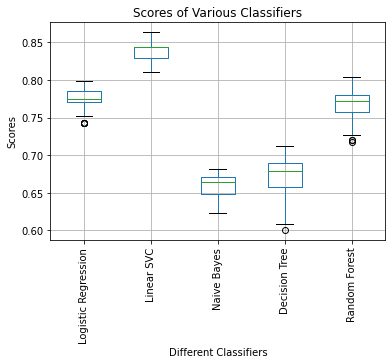

In [112]:
fit_eval(build_tfidf)

In [127]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Your solution
def build_lda(X_train):
    """
    Create a count vectorizer as described above, feed the vectors into an LDA and fit it. 
    It should return both the lda and count vectorizer as they're both going to be used later. 
    Just keep the return statement as is and you should be good to go.
    """
    # Your solution, 
    count_vectorizer = CountVectorizer(min_df=2)
    count_result = count_vectorizer.fit_transform(X_train)
    lda = LatentDirichletAllocation(random_state=0, n_components=25).fit(count_result)
    return lda, count_vectorizer

Xtrain,_,_,_ = train_test_split(bug_report_raw["description"], bug_report_raw["project"], random_state=0, stratify=bug_report_raw["project"]) # Stratify the same as fit_eval
lda, cv = build_lda(X_train)

# get the feature names from the vectorizer
feature_names = np.array(cv.get_feature_names())

for i, topic in enumerate(lda.components_, start=1):
    # Your solution

    # For each topic (a row in the components_), sort the features (ascending).
    # Invert rows with [::-1] to make sorting descending
    # Get top 5 
    sorting = np.argsort(topic)[::-1]

    # Get top 5 features
    top = feature_names[sorting]

    print('Top in '+str(i)+':', top)

Top in 1: ['configur' 'file' 'properti' ... 'paragraph' 'parallel' 'zzz']
Top in 2: ['session' 'context' 'security' ... 'pd' 'per' 'aa']
Top in 3: ['object' 'acl' 'list' ... 'partial' 'dm' 'recursive']
Top in 4: ['ldap' 'context' 'search' ... 'meanwhil' 'measur' 'aa']
Top in 5: ['collect' 'code' 'list' ... 'debugg' 'precis' 'cp']
Top in 6: ['user' 'authentication' 'authent' ... 'simultan' 'trump' 'firstnam']
Top in 7: ['bean' 'url' 'secur' ... 'polling' 'pom' 'zzz']
Top in 8: ['java' 'object' 'read' ... 'predict' 'endless' 'zzz']
Top in 9: ['java' 'mongo' 'data' ... 'dev' 'reach' 'somewhat']
Top in 10: ['id' 'string' 'object' ... 'delay' 'nov' 'programmat']
Top in 11: ['http' 'authentication' 'authent' ... 'merg' 'merged' 'aa']
Top in 12: ['queri' 'path' 'field' ... 'extens' 'extension' 'aa']
Top in 13: ['custom' 'file' 'page' ... 'endian' 'endless' 'zzz']
Top in 14: ['context' 'test' 'class' ... 'part' 'parameters' 'aa']
Top in 15: ['set' 'attribut' 'use' ... 'ljava' 'loader' 'aa']
To